# Granger Causality Estimation


### Acknowledgement
This work was funded by the German Federal Ministry of Education and Research ([BMBF](https://www.bmbf.de/)) in the project ALICE III under grant ref. 01IS18049B.

### Load packages

In [1]:
using TimeSeriesCausality
using Distributions: MvNormal
using Plots: plot
using Printf

### Data
We will generate (simulate) 1e6 two-channel samples using a design (evolution) matrix A of order 3. where:
- channel 1 is the causal (independent) time series
- channel 2 is the effect (dependent) time series

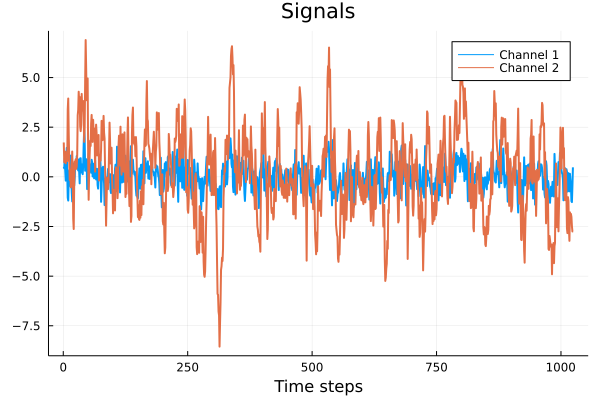

In [2]:
# design (evolution) matrix
#            Channel 1->    Channel 2->
#           t-1  t-2  t-3  t-1  t-2  t-3
designer = [0.4 -0.6  0.8  0.0  0.0  0.0;  # -> Channel 1
            0.5  0.9  0.0  0.0  0.0  0.7]  # -> Channel 2

# data generation
n_samples = 128*1024  # number of time steps
segment_length = 1024  # segment length
noise_cov = MvNormal([0.25 0.0; 0.0 0.64])  # uncorrelated Cov matrix of noise
noise = rand(noise_cov, n_samples)'  # sampling from the noise distribution

# pre-allocation and initial values
signal = zeros(n_samples, 2)
signal[1:3, :] = rand(3, 2) + noise[1:3, :]

# simulation
for t in 4:n_samples
    signal[t, :] = designer * reshape(signal[t-3:t-1, :], :, 1) + noise[t, :]
end

plot(1:segment_length, [signal[1:segment_length, 1], signal[1:segment_length, 2]],
     title = "Signals",
     label = ["Channel 1" "Channel 2"],
     xlabel = "Time steps",
     ylabel = "",
     lw = 2)

### Granger method of causal estimation
Granger method can estimate the causal index for a 2-channel signal. The larger the value, the stronger the causal dependence. A positive value indicates the flow of information from channel 1 to 2, and vice versa.
We have also included JackKnife method for calculate the standard deviation of error for the estimation.

In [3]:
granger_idx, err_std = granger_est(signal, segment_length; order=3, method="jackknife")
@printf "Granger causality index is %.3f with std error of %.3f" granger_idx err_std

Granger causality index is 0.584 with std error of 0.005

### Order as a hyperparameter
Since the order (time step delay) in which the signals interact is unknown by us, we have implemented Akaike and Bayesian information criteria to estimate the most informative order.

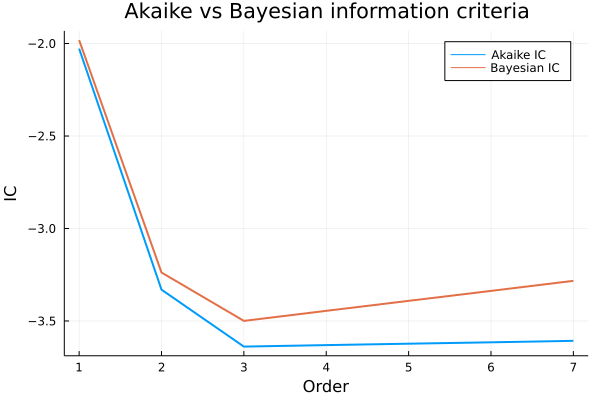

In [4]:
# the range of orders to look into
order_range = 1:7

# Akaike information criterion
aic = granger_aic(signal, segment_length, order_range)

# Bayesian information criterion
bic = granger_bic(signal, segment_length, order_range)

plot(order_range, [aic, bic],
     title = "Akaike vs Bayesian information criteria",
     label = ["Akaike IC" "Bayesian IC"],
     xlabel = "Order",
     ylabel = "IC",
     lw = 2)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*